# Khởi tạo

In [1]:
# Khai báo dữ liệu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from xgboost import plot_importance, plot_tree
import sqlalchemy
import warnings
from pmdarima.model_selection import train_test_split
warnings.filterwarnings('ignore')

# Make mysql connection
url = "mysql+mysqldb://root:@localhost/weather_iot"
engine = sqlalchemy.create_engine(url)

df_sensor = pd.read_csv("./weather.csv")
df_sensor.info()
# df_sensor.to_sql('sensor', con=engine, if_exists='replace', index=False)
# df_sensor = pd.read_sql_table('sensor', con=engine)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181960 entries, 0 to 181959
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   province  181960 non-null  object 
 1   max       181960 non-null  int64  
 2   min       181960 non-null  int64  
 3   wind      181960 non-null  int64  
 4   wind_d    181960 non-null  object 
 5   rain      181960 non-null  float64
 6   humidi    181960 non-null  int64  
 7   cloud     181960 non-null  int64  
 8   pressure  181960 non-null  int64  
 9   date      181960 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 13.9+ MB


## Lọc dữ liệu

In [2]:
# filter

# Lọc dữ liệu theo tỉnh
province_select = "Ha Noi"
df_province = df_sensor[df_sensor['province'].isin([province_select])] 


# Sắp xếp lại giá trị theo thứ tự ngày
df_province.sort_values(by=['date'])

# Tách ngày, tháng, năm ra từ cột date
df_province['day'] = df_province['date'].apply(lambda x: x.split('-')[2]).astype(int)
df_province['month'] = df_province['date'].apply(lambda x: x.split('-')[1]).astype(int)
df_province['year'] = df_province['date'].apply(lambda x: x.split('-')[0]).astype(int)
df_province['is_rain'] = df_province['rain'].apply(lambda x: 1 if x > 50 else 0)

# Đặt lại index là cột date
df_province = df_province.set_index("date")

# Sắp xếp lại dữ liệu theo thứ tự ngày
df_province.sort_index(inplace=True)
df_province.head()
df_province.head()

,province,max,min,wind,wind_d,rain,humidi,cloud,pressure,day,month,year,is_rain
date,,,,,,,,,,,,,
2009-01-01,Ha Noi,19,12,6,NNE,0.0,70,44,1025,1,1,2009,0
2009-01-02,Ha Noi,18,12,6,ESE,0.5,65,28,1025,2,1,2009,0
2009-01-03,Ha Noi,20,13,5,ESE,0.7,74,40,1022,3,1,2009,0
2009-01-04,Ha Noi,25,12,5,SSW,0.0,81,46,1018,4,1,2009,0
2009-01-05,Ha Noi,23,14,5,S,1.3,90,75,1017,5,1,2009,0


## Tính correlation

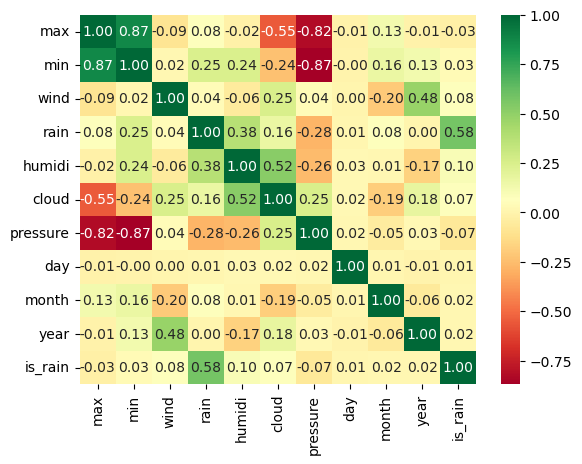

In [3]:
df_province.corr()
# plot correlation
sns.heatmap(df_province.corr(), cmap='RdYlGn', annot=True, fmt=".2f")
plt.show()

# corr = df_ha_noi.corr()
# plt.subplots(figsize=(8, 8))
# sns.heatmap(corr, cmap='RdYlGn', annot=True)
# plt.show()


In [ ]:
# df to mysql
df_province.corr().to_sql(name='weather_corr', con=engine, if_exists = 'replace', index=False)

# Data virtualization

In [ ]:
df_province['min'].plot(figsize=(15, 6))
df_province['max'].plot(figsize=(15, 6))

In [ ]:
# plot rain
df_province['rain'].plot(figsize=(15, 6))

In [ ]:
# plot humidity
df_province['wind'].plot(figsize=(15, 6))

In [ ]:
# draw cloud
df_province['cloud'].plot(figsize=(15, 6))
# draw rain
df_province['rain'].plot(figsize=(15, 6))

# Model

In [ ]:
# from XGBoost import XGBoostRegressor
label_select = 'is_rain'
feature_select = df_province.columns.drop([label_select] + ["wind_d", "province", "min", "wind", "cloud", "rain"]).tolist()
x_train,x_test = train_test_split(df_province, train_size=0.8)
# train split
X_train = x_train[feature_select]
y_train = x_train[label_select]
# test split
X_test = x_test[feature_select]
y_test = x_test[label_select]

# remove index 
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
print(np.shape(X_train))
# reshape y_train (1000,1)
y_train = y_train.to_numpy().reshape(len(y_train), 1)
print(np.shape(y_train))

In [ ]:
from XGBoost import XGBoostRegressor
reg = XGBoostRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(y_pred)

In [ ]:
y_pred = reg.predict(X_test)
from sklearn.metrics import r2_score, mean_squared_error
print('r2 score: ', r2_score(y_test, y_pred))
print('rmse: ', np.sqrt(mean_squared_error(y_test, y_pred)))
# print socre
# print("Score: ", r2_score(y, y_pred))

## Model tự code

In [ ]:
corr = df_province.corr()
corr = corr.drop(['min', 'max', 'wind', 'cloud', 'rain'])
corr['max'].sort_values(ascending=False)

In [6]:
from pmdarima.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

def auto_train(df_province,feature_select,label_select, model_name = "xgboost", use_lib = True):

    # calc correlation
    corr = df_province.corr()
    # get correlation of label select
    corr = corr[label_select]
    # get only feature select
    corr = corr[feature_select]

    

    x_train,x_test = train_test_split(df_province, train_size=0.8)
    # train split
    X_train = x_train[feature_select]
    y_train = x_train[label_select]
    # test split
    X_test = x_test[feature_select]
    y_test = x_test[label_select]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    y_train = y_train.to_numpy().reshape(len(y_train), 1)

    reg = None
    if use_lib:
        # switch model
        if model_name == 'xgboost':
            reg = xgb.XGBRegressor(n_estimators=1500, booster='dart', n_jobs=8, importance_type='weight')
            reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                early_stopping_rounds=50,
                verbose=False) # too much logs 

        if model_name == "descision_tree":
            from sklearn.tree import DecisionTreeRegressor
            reg = DecisionTreeRegressor()
            reg.fit(X_train, y_train)
        
        if model_name == "random_forest":
            from sklearn.ensemble import RandomForestRegressor
            reg = RandomForestRegressor()
            reg.fit(X_train, y_train)
        if model_name == "regression":
            from sklearn.linear_model import LinearRegression
            reg = LinearRegression()
            reg.fit(X_train, y_train)
        if model_name =="ridge":
            from sklearn.linear_model import Ridge
            reg = Ridge()
            reg.fit(X_train, y_train)
        if model_name =="svm":
            from sklearn.svm import SVR
            reg = SVR()
            reg.fit(X_train, y_train)
        if model_name =="knn":
            from sklearn.neighbors import KNeighborsRegressor
            reg = KNeighborsRegressor()
            reg.fit(X_train, y_train)

    else: 
        if model_name == "descision_tree":
            from nguyen import DecisionTreeRegression
            reg = DecisionTreeRegression()
            reg.train(X_train, y_train)
        if model_name == "ridge":
            from hung import RidgeRegression
            X_train = np.array(x_train[feature_select].values.tolist())
            # y_train = y_train.to_numpy().reshape(len(y_train), 1)
            # Model training	
            reg = RidgeRegression(lamda = 0.1, learning_rate =  1e-7, iteration = 500000)          
            reg.train(X_train,y_train)
            X_test = np.array(x_test[feature_select].values.tolist())
            pred = reg.predict(X_test)
            r2 = r2_score(y_test, pred)
            rmse = np.sqrt(mean_squared_error(y_test, pred))

            error = pd.DataFrame({'r2_score': [r2_score(y_test, pred)], 'rmse': [np.sqrt(mean_squared_error(y_test, pred))]})
       
            # save y_test, y_pred to mysql
            y_test = x_test[label_select]
            
            y_test = y_test.reset_index(drop=True)
            y_test = y_test.to_frame()
            y_test['pred'] = np.reshape(pred, (len(pred), 1))
            y_test['date'] = x_test.index         
         

            try:               
                error.to_sql(f'error_{label_select}', con=engine, if_exists='replace', index=False)
                y_test.to_sql(f'test_{label_select}', con=engine, if_exists='replace', index=False)                
            except:
                print("Save SQL Error")
            return (reg,r2,rmse)
        if model_name == "regression":
            from linh import LinearRegression           
            X_train = np.array(x_train[feature_select].values.tolist())
            # y_train = y_train.to_numpy().reshape(len(y_train), 1)
            reg = LinearRegression(learning_rate = 0.0000001, iteration = 500000)
            reg.train(X_train, y_train)
            X_test = np.array(x_test[feature_select].values.tolist())
            pred = reg.predict(X_test)
            r2 = r2_score(y_test, pred)
            rmse = np.sqrt(mean_squared_error(y_test, pred))

            error = pd.DataFrame({'r2_score': [r2_score(y_test, pred)], 'rmse': [np.sqrt(mean_squared_error(y_test, pred))]})
       
            # save y_test, y_pred to mysql
            y_test = x_test[label_select]
            
            y_test = y_test.reset_index(drop=True)
            y_test = y_test.to_frame()
            y_test['pred'] = np.reshape(pred, (len(pred), 1))
            y_test['date'] = x_test.index
            try:               
                error.to_sql(f'error_{label_select}', con=engine, if_exists='replace', index=False)
                y_test.to_sql(f'test_{label_select}', con=engine, if_exists='replace', index=False)                
            except:
                print("Save SQL Error")


            return (reg,r2,rmse)


    if not reg:
        return (None,0,0)
 

    # predict
    pred = reg.predict(X_test)
    # plt.figure(figsize=(20, 6))
    # reset index to plot 

    # plt.plot(y_test_copy, label='actual')
    # plt.plot(pred, label='Predicted')
    # plt.legend()
    # plt.show()


    # reset train split
    X_train = x_train[feature_select]
    y_train = x_train[label_select]
    # test split
    X_test = x_test[feature_select]
    y_test = x_test[label_select]
    # error
    # r2 and rmse
    
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    # save error to mysql
    error = pd.DataFrame({'r2_score': [r2_score(y_test, pred)], 'rmse': [np.sqrt(mean_squared_error(y_test, pred))]})
    
    # save y_test, y_pred to mysql
    y_test = y_test.reset_index(drop=True)
    y_test = y_test.to_frame()
    y_test['pred'] = np.reshape(pred, (len(pred), 1))
    y_test['date'] = x_test.index   

    # save y_train to mysql
    y_train = x_train[label_select]
    y_train = y_train.to_frame()
    y_train['date'] = y_train.index

    try:
        corr.to_sql(name=f'corr_{label_select}', con=engine, if_exists = 'replace', index=True)
        error.to_sql(f'error_{label_select}', con=engine, if_exists='replace', index=False)
        y_test.to_sql(f'test_{label_select}', con=engine, if_exists='replace', index=False)
        y_train.to_sql(f'train_{label_select}', con=engine, if_exists='replace', index=False)
    except:
        print("Save SQL Error")
    
    return (reg, r2, rmse)


list_model = ["xgboost", "descision_tree", "random_forest","regression", "ridge"]
model_name = "descision_tree"
use_lib = False
# select feature
label_select = 'max'
# feature_select = df_province.columns.drop([label_select] + ["wind_d", "province", "min", "wind", "cloud", "rain"]).tolist()
feature_select = ['humidi', 'pressure', 'day', 'month', 'year']

# reg, r2 ,rmse = auto_train(df_province,feature_select,label_select, model_name = model_name, use_lib = use_lib)
# print("="*10)
# print("Feature select: ", feature_select)
# print("Label: ", label_select)
# print("Result: ", label_select, model_name, r2, rmse)

# Temp min
# label_select = 'min'
# feature_select = ['humidi', 'pressure', 'day', 'month', 'year']
# reg, r2 ,rmse = auto_train(df_province,feature_select,label_select, model_name = model_name, use_lib = use_lib)
# print("="*10)
# print("Feature select: ", feature_select)
# print("Label: ", label_select)
# print("Result: ", label_select, model_name, r2, rmse)

# Rain
# label_select = 'rain'
# feature_select = ['humidi', 'pressure', 'min', 'max', 'wind', 'cloud']
# reg, r2 ,rmse = auto_train(df_province,feature_select,label_select)
# print("Feature select: ", feature_select)
# print("Label: ", label_select)
# print("Result: ", label_select, model_name, r2, rmse)
# print("="*10)




for model_name in list_model:
    print("="*10,model_name,"="*10)
    reg, r2,rmse = auto_train(df_province,feature_select,label_select, model_name = model_name, use_lib = True)
    print("Lib", model_name, r2, rmse)
    reg, r2,rmse = auto_train(df_province,feature_select,label_select, model_name = model_name, use_lib = False)
    print("no lib >>", model_name, r2, rmse)


========== xgboost ==========
Save SQL Error
Lib xgboost 0.8153471823397089 2.588891676623342
no lib >> xgboost 0 0
========== descision_tree ==========
Save SQL Error
Lib descision_tree 0.6703637989180847 3.4590222845242216
Save SQL Error
no lib >> descision_tree 0.6411482465628269 3.609054547284472
========== random_forest ==========
Save SQL Error
Lib random_forest 0.821392746085926 2.546158623547193
no lib >> random_forest 0 0
========== regression ==========
Save SQL Error
Lib regression 0.7510019044118774 3.006311114508878
Save SQL Error
no lib >> regression 0.5680457543134301 3.959631615912929
========== ridge ==========
Save SQL Error
Lib ridge 0.7510029871133795 3.0063045784325877
Save SQL Error
no lib >> ridge 0.5683039483477955 3.958448034444057


In [ ]:
model_name = "ridge"
use_lib = False
label_select = 'max'
feature_select = ['humidi', 'pressure', 'day', 'month', 'year']
reg, r2 ,rmse = auto_train(df_province,feature_select,label_select, model_name = model_name, use_lib = use_lib)
print("="*10)
print("Feature select: ", feature_select)
print("Label: ", label_select)
print("Result: ", label_select, model_name, r2, rmse)

In [ ]:
# make function to predict
# ['humidi', 'pressure', 'day', 'month', 'year']
def predict(model, feature_value):
    input = np.array(feature_value).reshape(1, -1)
    return model.predict(input)


predict(reg, [88,1017,9,12,2022])
# predict to now
# date = pd.date_range(start='2020-01-01', end='2022-12-31').to_frame().reset_index(drop=True).rename(columns={0: 'date'})
# # predict temp min
# date['day'] = date['date'].apply(lambda x: x.day).astype(int)
# date['month'] = date['date'].apply(lambda x: x.month).astype(int)
# date['year'] = date['date'].apply(lambda x: x.year).astype(int)
# date['max'] = date.apply(lambda x: predict(x['day'], x['month'], x['year'])[0], axis=1)

In [ ]:
# save model
import pickle
pickle.dump(reg, open("model.pkl", "wb"))


## Model cây quyết định

In [10]:
list_model = ["xgboost", "descision_tree", "random_forest","regression", "ridge", "knn","svm"]
model_name = "descision_tree"
use_lib = False
# select feature
label_select = 'max'
# feature_select = df_province.columns.drop([label_select] + ["wind_d", "province", "min", "wind", "cloud", "rain"]).tolist()
feature_select = ['humidi', 'pressure', 'day', 'month', 'year']

reg, r2 ,rmse = auto_train(df_province,feature_select,label_select, model_name = model_name, use_lib = use_lib)
print("="*10)
print("Feature select: ", feature_select)
print("Label: ", label_select)
print("Result: ", label_select, model_name, r2, rmse)
use_lib = True

reg, r2 ,rmse = auto_train(df_province,feature_select,label_select, model_name = model_name, use_lib = use_lib)
print("="*10)
print("Feature select: ", feature_select)
print("Label: ", label_select)
print("Result: ", label_select, model_name, r2, rmse)


Save SQL Error
Feature select:  ['humidi', 'pressure', 'day', 'month', 'year']
Label:  max
Result:  max descision_tree 0.6411482465628269 3.609054547284472
Save SQL Error
Feature select:  ['humidi', 'pressure', 'day', 'month', 'year']
Label:  max
Result:  max descision_tree 0.6834426783144282 3.389706460758791


## Model LinearRegression

In [7]:
list_model = ["xgboost", "descision_tree", "random_forest","regression", "ridge", "knn","svm"]
model_name = "regression"
use_lib = False
# select feature
label_select = 'max'
# feature_select = df_province.columns.drop([label_select] + ["wind_d", "province", "min", "wind", "cloud", "rain"]).tolist()
feature_select = ['humidi', 'pressure', 'day', 'month', 'year']

reg, r2 ,rmse = auto_train(df_province,feature_select,label_select, model_name = model_name, use_lib = use_lib)



from IPython.display import clear_output
clear_output(wait=True)
print("="*10)
print("Feature select: ", feature_select)
print("Label: ", label_select)
print("Result: ", label_select, model_name, r2, rmse)
use_lib = True

reg, r2 ,rmse = auto_train(df_province,feature_select,label_select, model_name = model_name, use_lib = use_lib)
print("="*10)
print("Feature select: ", feature_select)
print("Label: ", label_select)
print("Result: ", label_select, model_name, r2, rmse)


Feature select:  ['humidi', 'pressure', 'day', 'month', 'year']
Label:  max
Result:  max regression 0.5680457543134301 3.959631615912929
Save SQL Error
Feature select:  ['humidi', 'pressure', 'day', 'month', 'year']
Label:  max
Result:  max regression 0.7510019044118774 3.006311114508878


## Model ridge

In [8]:
list_model = ["xgboost", "descision_tree", "random_forest","regression", "ridge", "knn","svm"]
model_name = "ridge"
use_lib = False
# select feature
label_select = 'max'
# feature_select = df_province.columns.drop([label_select] + ["wind_d", "province", "min", "wind", "cloud", "rain"]).tolist()
feature_select = ['humidi', 'pressure', 'day', 'month', 'year']

reg, r2 ,rmse = auto_train(df_province,feature_select,label_select, model_name = model_name, use_lib = use_lib)

from IPython.display import clear_output
clear_output(wait=True)
print("="*10)
print("Feature select: ", feature_select)
print("Label: ", label_select)
print("Result: ", label_select, model_name, r2, rmse)
use_lib = True

reg, r2 ,rmse = auto_train(df_province,feature_select,label_select, model_name = model_name, use_lib = use_lib)
print("="*10)
print("Feature select: ", feature_select)
print("Label: ", label_select)
print("Result: ", label_select, model_name, r2, rmse)


Feature select:  ['humidi', 'pressure', 'day', 'month', 'year']
Label:  max
Result:  max ridge 0.5683039483477955 3.958448034444057
Save SQL Error
Feature select:  ['humidi', 'pressure', 'day', 'month', 'year']
Label:  max
Result:  max ridge 0.7510029871133795 3.0063045784325877


## Model knn

In [15]:
# filter

# Lọc dữ liệu theo tỉnh
province_select = "Ha Noi"
df_province = df_sensor[df_sensor['province'].isin([province_select])] 
# Sắp xếp lại giá trị theo thứ tự ngày
df_province.sort_values(by=['date'])
# Tách ngày, tháng, năm ra từ cột date
df_province['day'] = df_province['date'].apply(lambda x: x.split('-')[2]).astype(int)
df_province['month'] = df_province['date'].apply(lambda x: x.split('-')[1]).astype(int)
df_province['year'] = df_province['date'].apply(lambda x: x.split('-')[0]).astype(int)
# Đặt lại index là cột date
df_province = df_province.set_index("date")
# Sắp xếp lại dữ liệu theo thứ tự ngày
df_province.sort_index(inplace=True)
def fun1(x):
      if x > 1.6: return 1
      else: return 0
df_province["du_doan"]=df_province["rain"].map(lambda x:fun1(x))
df_province.head()

,province,max,min,wind,wind_d,rain,humidi,cloud,pressure,day,month,year,du_doan
date,,,,,,,,,,,,,
2009-01-01,Ha Noi,19,12,6,NNE,0.0,70,44,1025,1,1,2009,0
2009-01-02,Ha Noi,18,12,6,ESE,0.5,65,28,1025,2,1,2009,0
2009-01-03,Ha Noi,20,13,5,ESE,0.7,74,40,1022,3,1,2009,0
2009-01-04,Ha Noi,25,12,5,SSW,0.0,81,46,1018,4,1,2009,0
2009-01-05,Ha Noi,23,14,5,S,1.3,90,75,1017,5,1,2009,0


In [16]:
import math
def KNN(X_train, y_train, arr_train,number):
    X = X_train.to_numpy()
    y = y_train.to_numpy()
    arr = []
    arr_res=[]
    number_0=0
    number_1=0
    for index in range(len(X)):
        sum = 0
        for i in range(len(X[index])):
            sum += (X[index][i]-arr_train[i])**2
        dis = math.sqrt(sum)
        if len(arr_res)<number:
            arr.append(dis)
            arr_res.append(y[index])
        else:
            for index_2 in range(len(arr_res)):
                if arr[index_2]>dis:
                    arr[index_2]=dis
                    arr_res[index_2] = y[index]
                    break
    for arr_res_item in arr_res:
        if arr_res_item == 1:
            number_1 +=1
    res = {'1':float(number_1)/number*100,
            '0':100-float(number_1)/number*100}
    out_come =0
    if float(number_1)/number*100>50: out_come=1
    return {'res':res,
            'out_come':out_come}

In [17]:
label_select = 'du_doan'

feature_select = ['max','min','wind','rain','humidi', 'cloud']
x_train,x_test = train_test_split(df_province, train_size=0.8)
# train split
X_train = x_train[feature_select]
y_train = x_train[label_select]
# test split
X_test = x_test[feature_select]
y_test = x_test[label_select]


X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [18]:
y_pred_label = []
y_pred = []
for arr_train in list(X_test.to_numpy()):
    # print(arr_train)
    # break
    result = KNN(X_train,y_train,arr_train,200)
    y_pred.append(result)
    y_pred_label.append(result['out_come'])

In [19]:
from sklearn.metrics import accuracy_score
error = pd.DataFrame({'accuracy': [accuracy_score(y_test,y_pred_label)]})

# save y_test, y_pred to mysql
y_test = x_test[label_select]
y_test = y_test.reset_index(drop=True)
y_test = y_test.to_frame()
y_test['pred'] = np.reshape(y_pred_label, (len(y_pred_label), 1))
y_test['date'] = x_test.index
try:               
    error.to_sql(f'error_{label_select}', con=engine, if_exists='replace', index=False)
    y_test.to_sql(f'test_{label_select}', con=engine, if_exists='replace', index=False)                
except:
    print("Save SQL Error")
print(error)

   accuracy
0  0.667033
